# 🧵 Research-Grade GSM Prediction from Fabric Microscopy Images

## Hybrid Deep Learning Approach for Fabric Weight Estimation

**Research Objective:** Develop a highly accurate GSM (Grams per Square Meter) prediction model combining:
- Pre-trained CNN features (transfer learning from ImageNet)
- Engineered fabric-specific features (thread count, texture, frequency domain)

**Target Accuracy:** ±5 GSM prediction error

**Dataset:** 1,062 augmented microscopy images with 64 extracted fabric features

---

### Quick Start (Google Colab)
1. Upload `augmented_features_dataset` folder to Google Drive
2. Mount Drive and set `DATASET_PATH` below
3. Run all cells sequentially
4. Model will be saved to Drive after training

## 1. Environment Setup & GPU Configuration

In [ ]:
# Check GPU availability
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set random seeds for reproducibility.
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("\n✅ Environment configured with seed:", SEED)

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB

✅ Environment configured with seed: 42


## 2. Mount Google Drive & Load Dataset

In [2]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    BASE_PATH = '/content/drive/MyDrive/fabric_gsm_pipeline'
except:
    IN_COLAB = False
    BASE_PATH = 'data'
    print("Running locally")

# Dataset paths
DATASET_PATH = f"{BASE_PATH}/augmented_features_dataset"
IMAGES_PATH = f"{DATASET_PATH}/images"
TRAIN_CSV = f"{DATASET_PATH}/dataset_train.csv"
VAL_CSV = f"{DATASET_PATH}/dataset_val.csv"
TEST_CSV = f"{DATASET_PATH}/dataset_test.csv"

print(f"Dataset path: {DATASET_PATH}")

Mounted at /content/drive
Dataset path: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset


## 3. Import Libraries & Visualization Setup

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 4. Load and Explore Dataset

📊 DATASET STATISTICS
Train samples: 738
Val samples:   156
Test samples:  168
Total:         1062

🔬 Extracted features: 64
Feature names: ['weft_count_autocorr', 'weft_count_fft', 'weft_count_direct', 'weft_count', 'weft_spacing_avg']... (showing first 5)

📊 GSM Distribution:
Train - Mean: 153.54, Std: 48.13, Range: [85, 297]
Val   - Mean: 170.23, Std: 65.66, Range: [95, 297]
Test  - Mean: 153.68, Std: 48.01, Range: [100, 297]


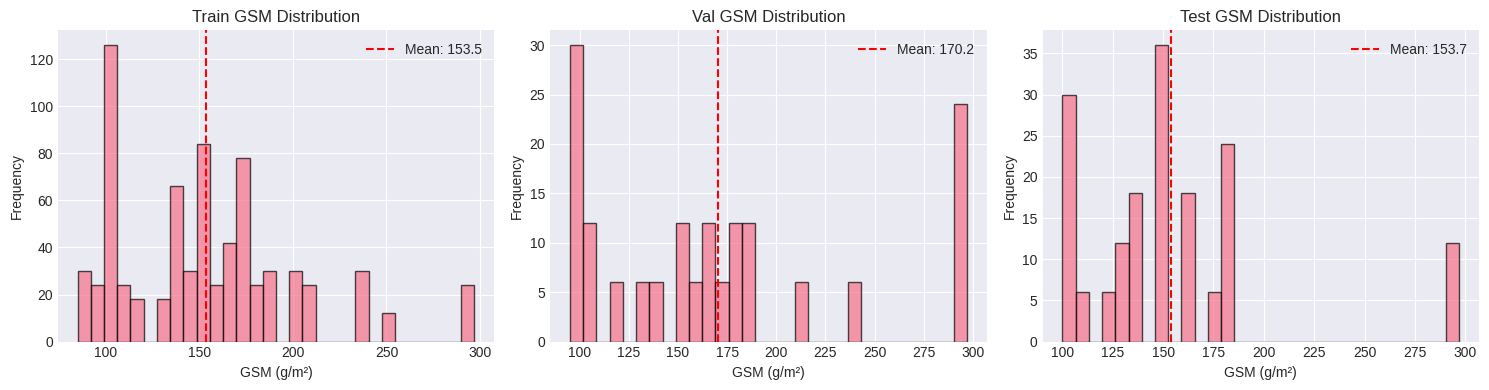


✅ Dataset loaded and explored


In [4]:
# Load datasets
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

print("="*80)
print("📊 DATASET STATISTICS")
print("="*80)
print(f"Train samples: {len(df_train)}")
print(f"Val samples:   {len(df_val)}")
print(f"Test samples:  {len(df_test)}")
print(f"Total:         {len(df_train) + len(df_val) + len(df_test)}")

# Feature columns (exclude metadata)
meta_cols = ['image_name', 'gsm', 'source', 'augmentation', 'original_image', 'split']
feature_cols = [col for col in df_train.columns if col not in meta_cols]

print(f"\n🔬 Extracted features: {len(feature_cols)}")
print(f"Feature names: {feature_cols[:5]}... (showing first 5)")

# GSM distribution
print("\n📊 GSM Distribution:")
print(f"Train - Mean: {df_train['gsm'].mean():.2f}, Std: {df_train['gsm'].std():.2f}, Range: [{df_train['gsm'].min():.0f}, {df_train['gsm'].max():.0f}]")
print(f"Val   - Mean: {df_val['gsm'].mean():.2f}, Std: {df_val['gsm'].std():.2f}, Range: [{df_val['gsm'].min():.0f}, {df_val['gsm'].max():.0f}]")
print(f"Test  - Mean: {df_test['gsm'].mean():.2f}, Std: {df_test['gsm'].std():.2f}, Range: [{df_test['gsm'].min():.0f}, {df_test['gsm'].max():.0f}]")

# Visualize GSM distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (df, name) in enumerate([(df_train, 'Train'), (df_val, 'Val'), (df_test, 'Test')]):
    axes[i].hist(df['gsm'], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{name} GSM Distribution')
    axes[i].set_xlabel('GSM (g/m²)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(df['gsm'].mean(), color='red', linestyle='--', label=f"Mean: {df['gsm'].mean():.1f}")
    axes[i].legend()
plt.tight_layout()
plt.show()

print("\n✅ Dataset loaded and explored")

## 5. Feature Engineering & Preprocessing

In [5]:
# Handle missing values
print("🔧 Preprocessing extracted features...")

# Fill NaN with median for each feature
for col in feature_cols:
    if df_train[col].isna().any():
        median_val = df_train[col].median()
        df_train[col].fillna(median_val, inplace=True)
        df_val[col].fillna(median_val, inplace=True)
        df_test[col].fillna(median_val, inplace=True)

# Remove features with zero variance
zero_var_cols = []
for col in feature_cols:
    if df_train[col].std() == 0:
        zero_var_cols.append(col)

if zero_var_cols:
    print(f"Removing {len(zero_var_cols)} zero-variance features: {zero_var_cols}")
    feature_cols = [col for col in feature_cols if col not in zero_var_cols]

# Standardize features using RobustScaler (handles outliers better)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(df_train[feature_cols])
X_val_scaled = scaler.transform(df_val[feature_cols])
X_test_scaled = scaler.transform(df_test[feature_cols])

print(f"\n✅ Features preprocessed: {len(feature_cols)} features")
print(f"Scaled shapes - Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

🔧 Preprocessing extracted features...

✅ Features preprocessed: 64 features
Scaled shapes - Train: (738, 64), Val: (156, 64), Test: (168, 64)


## 6. Custom Dataset Class (Hybrid: Images + Features)

In [6]:
class FabricGSMDataset(Dataset):
    """Dataset combining images and engineered features for GSM prediction."""

    def __init__(self, dataframe, features_array, images_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.features = features_array
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image
        img_name = self.df.iloc[idx]['image_name']
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get engineered features
        features = torch.tensor(self.features[idx], dtype=torch.float32)

        # Get target GSM
        gsm = torch.tensor(self.df.iloc[idx]['gsm'], dtype=torch.float32)

        return image, features, gsm

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FabricGSMDataset(df_train, X_train_scaled, IMAGES_PATH, transform=train_transform)
val_dataset = FabricGSMDataset(df_val, X_val_scaled, IMAGES_PATH, transform=val_test_transform)
test_dataset = FabricGSMDataset(df_test, X_test_scaled, IMAGES_PATH, transform=val_test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Datasets created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

✅ Datasets created:
  Train batches: 24
  Val batches:   5
  Test batches:  6


## 7. Hybrid Deep Learning Model Architecture

In [7]:
class HybridGSMPredictor(nn.Module):
    """Hybrid model combining EfficientNet-B3 CNN with engineered fabric features."""

    def __init__(self, num_features, dropout=0.5):
        super(HybridGSMPredictor, self).__init__()

        # Pre-trained EfficientNet-B3 backbone
        efficientnet = models.efficientnet_b3(weights='IMAGENET1K_V1')

        # Freeze early layers (feature extraction)
        for param in list(efficientnet.parameters())[:-30]:
            param.requires_grad = False

        # Remove classifier head
        self.cnn_features = nn.Sequential(*list(efficientnet.children())[:-1])
        cnn_feature_size = 1536  # EfficientNet-B3 output

        # Feature processing branch
        self.feature_branch = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout/2)
        )

        # Fusion and prediction head
        combined_size = cnn_feature_size + 128
        self.fusion = nn.Sequential(
            nn.Linear(combined_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(256, 1)
        )

    def forward(self, images, features):
        # Extract CNN features
        cnn_out = self.cnn_features(images)
        cnn_out = torch.flatten(cnn_out, 1)

        # Process engineered features
        feat_out = self.feature_branch(features)

        # Concatenate and predict
        combined = torch.cat([cnn_out, feat_out], dim=1)
        output = self.fusion(combined)

        return output.squeeze()

# Initialize model
model = HybridGSMPredictor(num_features=len(feature_cols), dropout=0.5)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*80)
print("🧠 MODEL ARCHITECTURE")
print("="*80)
print(f"Backbone: EfficientNet-B3 (ImageNet pretrained)")
print(f"Input features: {len(feature_cols)} fabric-specific features")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*80)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 127MB/s]


🧠 MODEL ARCHITECTURE
Backbone: EfficientNet-B3 (ImageNet pretrained)
Input features: 64 fabric-specific features
Total parameters: 11,732,137
Trainable parameters: 4,590,075


## 8. Training Configuration & Loss Functions

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# =========================
# Hyperparameters
# =========================
EPOCHS = 100
INITIAL_LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 15   # Early stopping patience

# =========================
# Custom Huber Loss
# =========================
class HuberLoss(nn.Module):
    """
    Huber loss - robust to outliers.
    Suitable for GSM regression with tolerance.
    """
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, pred, target):
        error = pred - target
        abs_error = torch.abs(error)
        quadratic = torch.clamp(abs_error, max=self.delta)
        linear = abs_error - quadratic
        loss = 0.5 * quadratic ** 2 + self.delta * linear
        return loss.mean()

# =========================
# Loss, Optimizer
# =========================
criterion = HuberLoss(delta=5.0)   # ±5 GSM tolerance
optimizer = optim.AdamW(
    model.parameters(),
    lr=INITIAL_LR,
    weight_decay=WEIGHT_DECAY
)

# =========================
# LR Scheduler (Colab-safe)
# =========================
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# =========================
# Utility: Get Current LR
# =========================
def get_current_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

# =========================
# Config Summary
# =========================
print("✅ Training configuration loaded")
print(f"• Epochs: {EPOCHS}")
print(f"• Initial LR: {INITIAL_LR}")
print("• Loss: Huber Loss (delta=5.0)")
print("• Optimizer: AdamW")
print("• Scheduler: ReduceLROnPlateau")
print(f"• Early Stopping Patience: {PATIENCE}")
print(f"• PyTorch Version: {torch.__version__}")


✅ Training configuration loaded
• Epochs: 100
• Initial LR: 0.001
• Loss: Huber Loss (delta=5.0)
• Optimizer: AdamW
• Scheduler: ReduceLROnPlateau
• Early Stopping Patience: 15
• PyTorch Version: 2.9.0+cu126


## 9. Training Loop with Early Stopping

In [9]:
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model and return metrics."""
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for images, features, targets in dataloader:
            images = images.to(device)
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    return total_loss / len(dataloader), mae, rmse, r2, predictions, actuals

# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_mae': [], 'val_mae': [],
    'train_rmse': [], 'val_rmse': [],
    'train_r2': [], 'val_r2': [],
    'lr': []
}

best_val_mae = float('inf')
epochs_no_improve = 0
best_model_state = None

print("\n" + "="*80)
print("🚀 TRAINING STARTED")
print("="*80)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for images, features, targets in pbar:
        images = images.to(device)
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, features)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.detach().cpu().numpy())
        train_actuals.extend(targets.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate training metrics
    train_preds = np.array(train_preds)
    train_actuals = np.array(train_actuals)
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(mean_squared_error(train_actuals, train_preds))
    train_r2 = r2_score(train_actuals, train_preds)

    # Validation phase
    val_loss, val_mae, val_rmse, val_r2, val_preds, val_actuals = evaluate_model(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step(val_mae)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['train_rmse'].append(train_rmse)
    history['val_rmse'].append(val_rmse)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)
    history['lr'].append(current_lr)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train - Loss: {train_loss/len(train_loader):.4f}, MAE: {train_mae:.3f}, RMSE: {train_rmse:.3f}, R²: {train_r2:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, MAE: {val_mae:.3f}, RMSE: {val_rmse:.3f}, R²: {val_r2:.4f}")
    print(f"  LR: {current_lr:.6f}")

    # Early stopping and best model saving
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        epochs_no_improve = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✅ New best model! Val MAE: {val_mae:.3f}")
    else:
        epochs_no_improve += 1
        print(f"  ⏳ No improvement for {epochs_no_improve} epochs")

    if epochs_no_improve >= PATIENCE:
        print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
        break

    print("-" * 80)

# Load best model
model.load_state_dict(best_model_state)
print(f"\n✅ Training complete! Best Val MAE: {best_val_mae:.3f}")


🚀 TRAINING STARTED


Epoch 1/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 1/100:
  Train - Loss: 745.5395, MAE: 152.408, RMSE: 159.825, R²: -10.0442
  Val   - Loss: 839.4163, MAE: 169.011, RMSE: 181.255, R²: -6.6706
  LR: 0.001000
  ✅ New best model! Val MAE: 169.011
--------------------------------------------------------------------------------


Epoch 2/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 2/100:
  Train - Loss: 743.5426, MAE: 149.776, RMSE: 157.317, R²: -9.7004
  Val   - Loss: 824.7636, MAE: 166.076, RMSE: 178.602, R²: -6.4477
  LR: 0.001000
  ✅ New best model! Val MAE: 166.076
--------------------------------------------------------------------------------


Epoch 3/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 3/100:
  Train - Loss: 731.5424, MAE: 146.953, RMSE: 154.582, R²: -9.3316
  Val   - Loss: 811.1422, MAE: 163.343, RMSE: 176.107, R²: -6.2411
  LR: 0.001000
  ✅ New best model! Val MAE: 163.343
--------------------------------------------------------------------------------


Epoch 4/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 4/100:
  Train - Loss: 718.4727, MAE: 143.836, RMSE: 151.693, R²: -8.9490
  Val   - Loss: 795.3357, MAE: 160.193, RMSE: 173.230, R²: -6.0064
  LR: 0.001000
  ✅ New best model! Val MAE: 160.193
--------------------------------------------------------------------------------


Epoch 5/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 5/100:
  Train - Loss: 684.5806, MAE: 140.276, RMSE: 148.296, R²: -8.5084
  Val   - Loss: 775.3108, MAE: 156.196, RMSE: 169.703, R²: -5.7240
  LR: 0.001000
  ✅ New best model! Val MAE: 156.196
--------------------------------------------------------------------------------


Epoch 6/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 6/100:
  Train - Loss: 669.4279, MAE: 135.811, RMSE: 144.119, R²: -7.9802
  Val   - Loss: 731.1339, MAE: 147.348, RMSE: 161.848, R²: -5.1160
  LR: 0.001000
  ✅ New best model! Val MAE: 147.348
--------------------------------------------------------------------------------


Epoch 7/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 7/100:
  Train - Loss: 632.9412, MAE: 129.851, RMSE: 138.555, R²: -7.3003
  Val   - Loss: 709.8029, MAE: 143.060, RMSE: 158.274, R²: -4.8488
  LR: 0.001000
  ✅ New best model! Val MAE: 143.060
--------------------------------------------------------------------------------


Epoch 8/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 8/100:
  Train - Loss: 596.8361, MAE: 123.557, RMSE: 132.683, R²: -6.6116
  Val   - Loss: 685.9616, MAE: 138.328, RMSE: 153.882, R²: -4.5287
  LR: 0.001000
  ✅ New best model! Val MAE: 138.328
--------------------------------------------------------------------------------


Epoch 9/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 9/100:
  Train - Loss: 575.2542, MAE: 117.225, RMSE: 126.653, R²: -5.9355
  Val   - Loss: 665.9378, MAE: 134.315, RMSE: 150.151, R²: -4.2639
  LR: 0.001000
  ✅ New best model! Val MAE: 134.315
--------------------------------------------------------------------------------


Epoch 10/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 10/100:
  Train - Loss: 541.2198, MAE: 110.998, RMSE: 121.182, R²: -5.3493
  Val   - Loss: 636.6919, MAE: 128.480, RMSE: 144.349, R²: -3.8650
  LR: 0.001000
  ✅ New best model! Val MAE: 128.480
--------------------------------------------------------------------------------


Epoch 11/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 11/100:
  Train - Loss: 506.0786, MAE: 104.410, RMSE: 114.844, R²: -4.7024
  Val   - Loss: 610.9113, MAE: 123.267, RMSE: 139.649, R²: -3.5533
  LR: 0.001000
  ✅ New best model! Val MAE: 123.267
--------------------------------------------------------------------------------


Epoch 12/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 12/100:
  Train - Loss: 487.0652, MAE: 97.885, RMSE: 109.752, R²: -4.2080
  Val   - Loss: 569.3782, MAE: 114.949, RMSE: 133.111, R²: -3.1369
  LR: 0.001000
  ✅ New best model! Val MAE: 114.949
--------------------------------------------------------------------------------


Epoch 13/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 13/100:
  Train - Loss: 433.3016, MAE: 90.132, RMSE: 102.665, R²: -3.5571
  Val   - Loss: 539.1804, MAE: 108.926, RMSE: 127.376, R²: -2.7881
  LR: 0.001000
  ✅ New best model! Val MAE: 108.926
--------------------------------------------------------------------------------


Epoch 14/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 14/100:
  Train - Loss: 392.7446, MAE: 82.392, RMSE: 95.715, R²: -2.9610
  Val   - Loss: 501.3722, MAE: 101.373, RMSE: 120.905, R²: -2.4130
  LR: 0.001000
  ✅ New best model! Val MAE: 101.373
--------------------------------------------------------------------------------


Epoch 15/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 15/100:
  Train - Loss: 352.5697, MAE: 74.007, RMSE: 88.727, R²: -2.4037
  Val   - Loss: 457.0056, MAE: 92.521, RMSE: 112.581, R²: -1.9592
  LR: 0.001000
  ✅ New best model! Val MAE: 92.521
--------------------------------------------------------------------------------


Epoch 16/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 16/100:
  Train - Loss: 317.2465, MAE: 65.811, RMSE: 81.345, R²: -1.8609
  Val   - Loss: 432.1847, MAE: 87.536, RMSE: 108.173, R²: -1.7320
  LR: 0.001000
  ✅ New best model! Val MAE: 87.536
--------------------------------------------------------------------------------


Epoch 17/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 17/100:
  Train - Loss: 275.2653, MAE: 57.786, RMSE: 74.256, R²: -1.3840
  Val   - Loss: 395.9520, MAE: 80.320, RMSE: 101.557, R²: -1.4080
  LR: 0.001000
  ✅ New best model! Val MAE: 80.320
--------------------------------------------------------------------------------


Epoch 18/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 18/100:
  Train - Loss: 240.4946, MAE: 51.214, RMSE: 66.542, R²: -0.9144
  Val   - Loss: 372.6674, MAE: 75.720, RMSE: 94.134, R²: -1.0689
  LR: 0.001000
  ✅ New best model! Val MAE: 75.720
--------------------------------------------------------------------------------


Epoch 19/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 19/100:
  Train - Loss: 203.4024, MAE: 43.385, RMSE: 58.271, R²: -0.4681
  Val   - Loss: 334.2106, MAE: 68.231, RMSE: 88.085, R²: -0.8116
  LR: 0.001000
  ✅ New best model! Val MAE: 68.231
--------------------------------------------------------------------------------


Epoch 20/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 20/100:
  Train - Loss: 170.5295, MAE: 37.027, RMSE: 51.757, R²: -0.1582
  Val   - Loss: 303.1780, MAE: 61.935, RMSE: 81.143, R²: -0.5373
  LR: 0.001000
  ✅ New best model! Val MAE: 61.935
--------------------------------------------------------------------------------


Epoch 21/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 21/100:
  Train - Loss: 148.0672, MAE: 32.461, RMSE: 45.854, R²: 0.0909
  Val   - Loss: 165.5139, MAE: 34.802, RMSE: 47.424, R²: 0.4749
  LR: 0.001000
  ✅ New best model! Val MAE: 34.802
--------------------------------------------------------------------------------


Epoch 22/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40><function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in 


Epoch 22/100:
  Train - Loss: 140.7645, MAE: 30.166, RMSE: 42.213, R²: 0.2296
  Val   - Loss: 187.6692, MAE: 39.075, RMSE: 52.728, R²: 0.3509
  LR: 0.001000
  ⏳ No improvement for 1 epochs
--------------------------------------------------------------------------------


Epoch 23/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 23/100:
  Train - Loss: 106.3898, MAE: 24.326, RMSE: 34.976, R²: 0.4711
  Val   - Loss: 115.6571, MAE: 25.320, RMSE: 36.185, R²: 0.6943
  LR: 0.001000
  ✅ New best model! Val MAE: 25.320
--------------------------------------------------------------------------------


Epoch 24/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 24/100:
  Train - Loss: 115.7511, MAE: 23.531, RMSE: 32.932, R²: 0.5311
  Val   - Loss: 164.1208, MAE: 34.469, RMSE: 47.485, R²: 0.4736
  LR: 0.001000
  ⏳ No improvement for 1 epochs
--------------------------------------------------------------------------------


Epoch 25/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 25/100:
  Train - Loss: 96.1147, MAE: 20.853, RMSE: 29.762, R²: 0.6170
  Val   - Loss: 121.5387, MAE: 26.502, RMSE: 37.343, R²: 0.6744
  LR: 0.001000
  ⏳ No improvement for 2 epochs
--------------------------------------------------------------------------------


Epoch 26/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 26/100:
  Train - Loss: 107.3634, MAE: 20.884, RMSE: 30.178, R²: 0.6062
  Val   - Loss: 115.0896, MAE: 25.306, RMSE: 32.952, R²: 0.7465
  LR: 0.001000
  ✅ New best model! Val MAE: 25.306
--------------------------------------------------------------------------------


Epoch 27/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 27/100:
  Train - Loss: 89.7282, MAE: 19.580, RMSE: 28.952, R²: 0.6376
  Val   - Loss: 126.9910, MAE: 27.535, RMSE: 36.431, R²: 0.6901
  LR: 0.001000
  ⏳ No improvement for 1 epochs
--------------------------------------------------------------------------------


Epoch 28/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 28/100:
  Train - Loss: 96.7254, MAE: 21.334, RMSE: 29.531, R²: 0.6230
  Val   - Loss: 119.2052, MAE: 26.091, RMSE: 35.105, R²: 0.7123
  LR: 0.001000
  ⏳ No improvement for 2 epochs
--------------------------------------------------------------------------------


Epoch 29/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 29/100:
  Train - Loss: 83.7550, MAE: 18.325, RMSE: 26.263, R²: 0.7018
  Val   - Loss: 108.8524, MAE: 23.556, RMSE: 35.613, R²: 0.7039
  LR: 0.001000
  ✅ New best model! Val MAE: 23.556
--------------------------------------------------------------------------------


Epoch 30/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 30/100:
  Train - Loss: 74.5276, MAE: 17.307, RMSE: 24.335, R²: 0.7440
  Val   - Loss: 110.5952, MAE: 24.209, RMSE: 33.856, R²: 0.7324
  LR: 0.001000
  ⏳ No improvement for 1 epochs
--------------------------------------------------------------------------------


Epoch 31/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 31/100:
  Train - Loss: 85.0461, MAE: 17.865, RMSE: 25.201, R²: 0.7254
  Val   - Loss: 106.6584, MAE: 23.437, RMSE: 31.984, R²: 0.7612
  LR: 0.001000
  ✅ New best model! Val MAE: 23.437
--------------------------------------------------------------------------------


Epoch 32/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 32/100:
  Train - Loss: 90.2091, MAE: 17.321, RMSE: 23.582, R²: 0.7596
  Val   - Loss: 82.3052, MAE: 18.157, RMSE: 27.624, R²: 0.8218
  LR: 0.001000
  ✅ New best model! Val MAE: 18.157
--------------------------------------------------------------------------------


Epoch 33/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 33/100:
  Train - Loss: 78.4554, MAE: 18.322, RMSE: 26.368, R²: 0.6994
  Val   - Loss: 83.7973, MAE: 19.152, RMSE: 27.686, R²: 0.8210
  LR: 0.001000
  ⏳ No improvement for 1 epochs
--------------------------------------------------------------------------------


Epoch 34/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 34/100:
  Train - Loss: 78.2763, MAE: 16.827, RMSE: 23.822, R²: 0.7546
  Val   - Loss: 89.9470, MAE: 20.201, RMSE: 28.742, R²: 0.8071
  LR: 0.001000
  ⏳ No improvement for 2 epochs
--------------------------------------------------------------------------------


Epoch 35/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 35/100:
  Train - Loss: 79.1840, MAE: 15.946, RMSE: 22.237, R²: 0.7862
  Val   - Loss: 110.2212, MAE: 24.392, RMSE: 32.492, R²: 0.7535
  LR: 0.001000
  ⏳ No improvement for 3 epochs
--------------------------------------------------------------------------------


Epoch 36/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 36/100:
  Train - Loss: 81.1606, MAE: 18.365, RMSE: 24.362, R²: 0.7434
  Val   - Loss: 117.6135, MAE: 25.800, RMSE: 32.750, R²: 0.7496
  LR: 0.001000
  ⏳ No improvement for 4 epochs
--------------------------------------------------------------------------------


Epoch 37/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 37/100:
  Train - Loss: 77.7654, MAE: 17.691, RMSE: 23.559, R²: 0.7600
  Val   - Loss: 125.3517, MAE: 27.363, RMSE: 35.620, R²: 0.7038
  LR: 0.001000
  ⏳ No improvement for 5 epochs
--------------------------------------------------------------------------------


Epoch 38/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 38/100:
  Train - Loss: 65.9178, MAE: 15.805, RMSE: 21.470, R²: 0.8007
  Val   - Loss: 104.2785, MAE: 23.433, RMSE: 33.244, R²: 0.7420
  LR: 0.000500
  ⏳ No improvement for 6 epochs
--------------------------------------------------------------------------------


Epoch 39/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 39/100:
  Train - Loss: 69.7976, MAE: 15.845, RMSE: 21.983, R²: 0.7911
  Val   - Loss: 114.3448, MAE: 25.148, RMSE: 33.707, R²: 0.7347
  LR: 0.000500
  ⏳ No improvement for 7 epochs
--------------------------------------------------------------------------------


Epoch 40/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 40/100:
  Train - Loss: 66.4871, MAE: 15.140, RMSE: 20.528, R²: 0.8178
  Val   - Loss: 87.9616, MAE: 19.848, RMSE: 27.995, R²: 0.8170
  LR: 0.000500
  ⏳ No improvement for 8 epochs
--------------------------------------------------------------------------------


Epoch 41/100:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79122d175e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 41/100:
  Train - Loss: 68.0814, MAE: 14.445, RMSE: 19.481, R²: 0.8359
  Val   - Loss: 106.0378, MAE: 23.519, RMSE: 31.581, R²: 0.7671
  LR: 0.000500
  ⏳ No improvement for 9 epochs
--------------------------------------------------------------------------------


Epoch 42/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 42/100:
  Train - Loss: 62.9300, MAE: 15.057, RMSE: 20.196, R²: 0.8237
  Val   - Loss: 99.6362, MAE: 22.392, RMSE: 29.547, R²: 0.7962
  LR: 0.000500
  ⏳ No improvement for 10 epochs
--------------------------------------------------------------------------------


Epoch 43/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 43/100:
  Train - Loss: 61.6782, MAE: 14.059, RMSE: 19.086, R²: 0.8425
  Val   - Loss: 93.6694, MAE: 21.183, RMSE: 29.219, R²: 0.8007
  LR: 0.000500
  ⏳ No improvement for 11 epochs
--------------------------------------------------------------------------------


Epoch 44/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 44/100:
  Train - Loss: 60.7419, MAE: 14.529, RMSE: 19.226, R²: 0.8402
  Val   - Loss: 101.6859, MAE: 22.771, RMSE: 31.699, R²: 0.7654
  LR: 0.000250
  ⏳ No improvement for 12 epochs
--------------------------------------------------------------------------------


Epoch 45/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 45/100:
  Train - Loss: 73.3416, MAE: 14.453, RMSE: 20.965, R²: 0.8100
  Val   - Loss: 94.8240, MAE: 21.271, RMSE: 30.486, R²: 0.7830
  LR: 0.000250
  ⏳ No improvement for 13 epochs
--------------------------------------------------------------------------------


Epoch 46/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 46/100:
  Train - Loss: 65.9637, MAE: 14.583, RMSE: 19.595, R²: 0.8340
  Val   - Loss: 88.3649, MAE: 20.098, RMSE: 30.119, R²: 0.7882
  LR: 0.000250
  ⏳ No improvement for 14 epochs
--------------------------------------------------------------------------------


Epoch 47/100:   0%|          | 0/24 [00:00<?, ?it/s]


Epoch 47/100:
  Train - Loss: 70.1085, MAE: 14.686, RMSE: 20.387, R²: 0.8203
  Val   - Loss: 93.8466, MAE: 21.228, RMSE: 30.058, R²: 0.7891
  LR: 0.000250
  ⏳ No improvement for 15 epochs

⏹️ Early stopping triggered after 47 epochs

✅ Training complete! Best Val MAE: 18.157


## 10. Training History Visualization

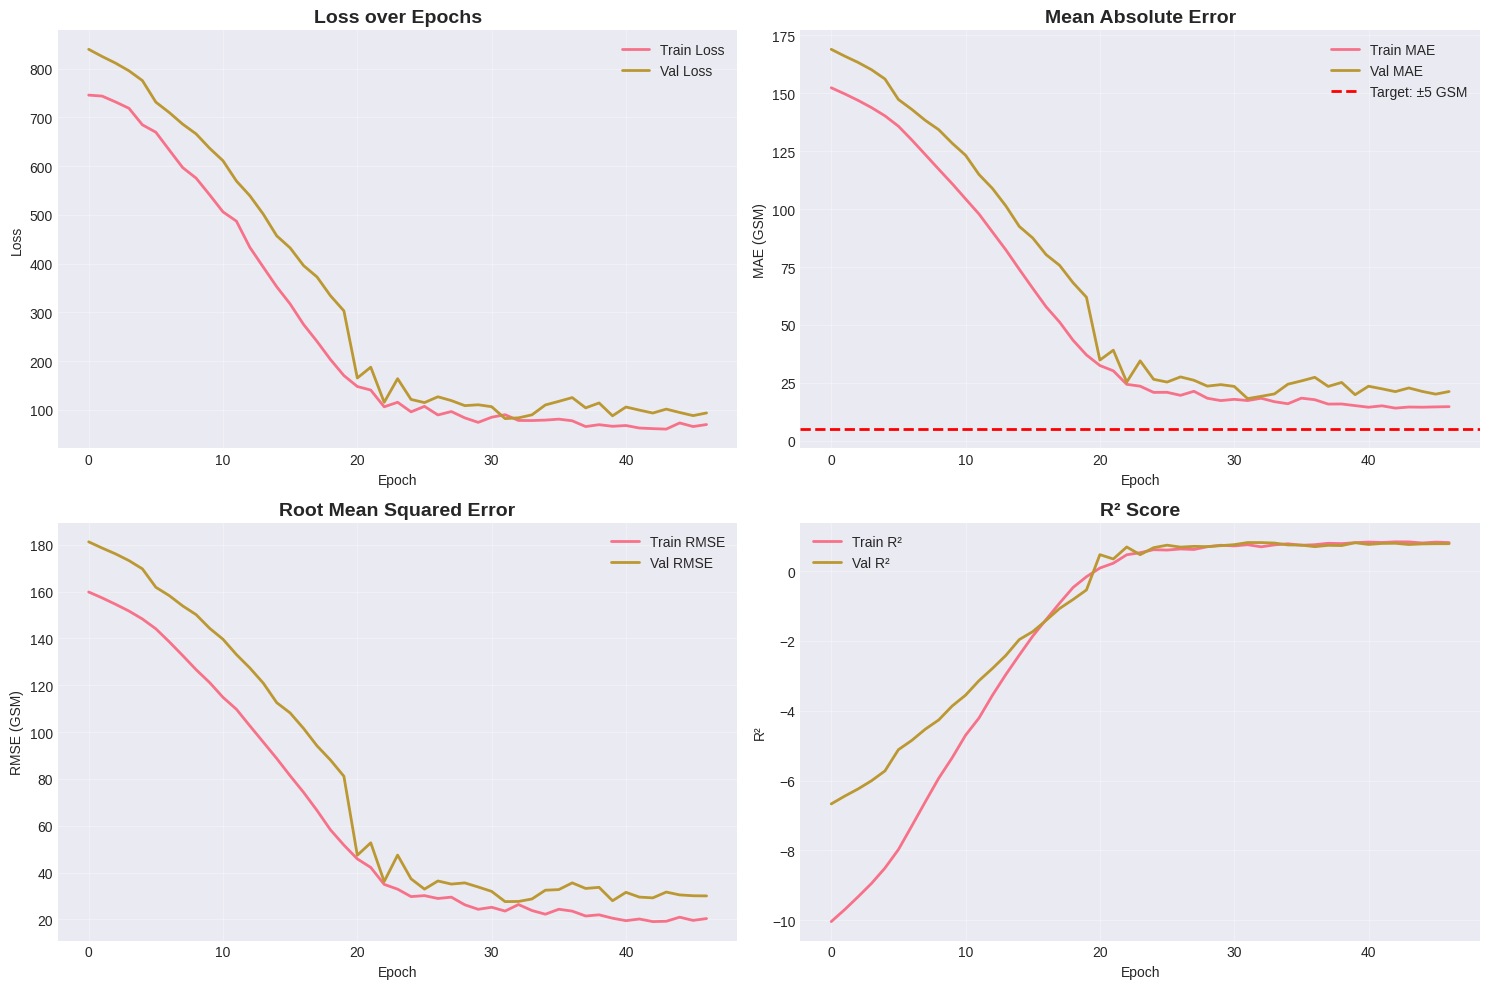

✅ Training history saved


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE plot
axes[0, 1].plot(history['train_mae'], label='Train MAE', linewidth=2)
axes[0, 1].plot(history['val_mae'], label='Val MAE', linewidth=2)
axes[0, 1].axhline(y=5, color='r', linestyle='--', label='Target: ±5 GSM', linewidth=2)
axes[0, 1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE (GSM)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# RMSE plot
axes[1, 0].plot(history['train_rmse'], label='Train RMSE', linewidth=2)
axes[1, 0].plot(history['val_rmse'], label='Val RMSE', linewidth=2)
axes[1, 0].set_title('Root Mean Squared Error', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE (GSM)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# R² plot
axes[1, 1].plot(history['train_r2'], label='Train R²', linewidth=2)
axes[1, 1].plot(history['val_r2'], label='Val R²', linewidth=2)
axes[1, 1].set_title('R² Score', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('R²')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{DATASET_PATH}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history saved")

## 10.1. Detailed Validation Set Analysis

📊 VALIDATION SET DETAILED METRICS
Samples: 156
MAE:     21.2280 GSM
RMSE:    30.0581 GSM
R²:      0.7891
MSE:     903.4903

📈 Error Percentiles:
  10th percentile: 2.56 GSM
  25th percentile: 5.21 GSM
  50th percentile (Median): 10.05 GSM
  75th percentile: 34.20 GSM
  90th percentile: 52.07 GSM
  95th percentile: 57.06 GSM
  99th percentile: 88.70 GSM

✅ Accuracy Thresholds:
  Within ±5 GSM:  24.36% (38/156 samples)
  Within ±10 GSM: 50.00% (78/156 samples)
  Within ±15 GSM: 53.85% (84/156 samples)


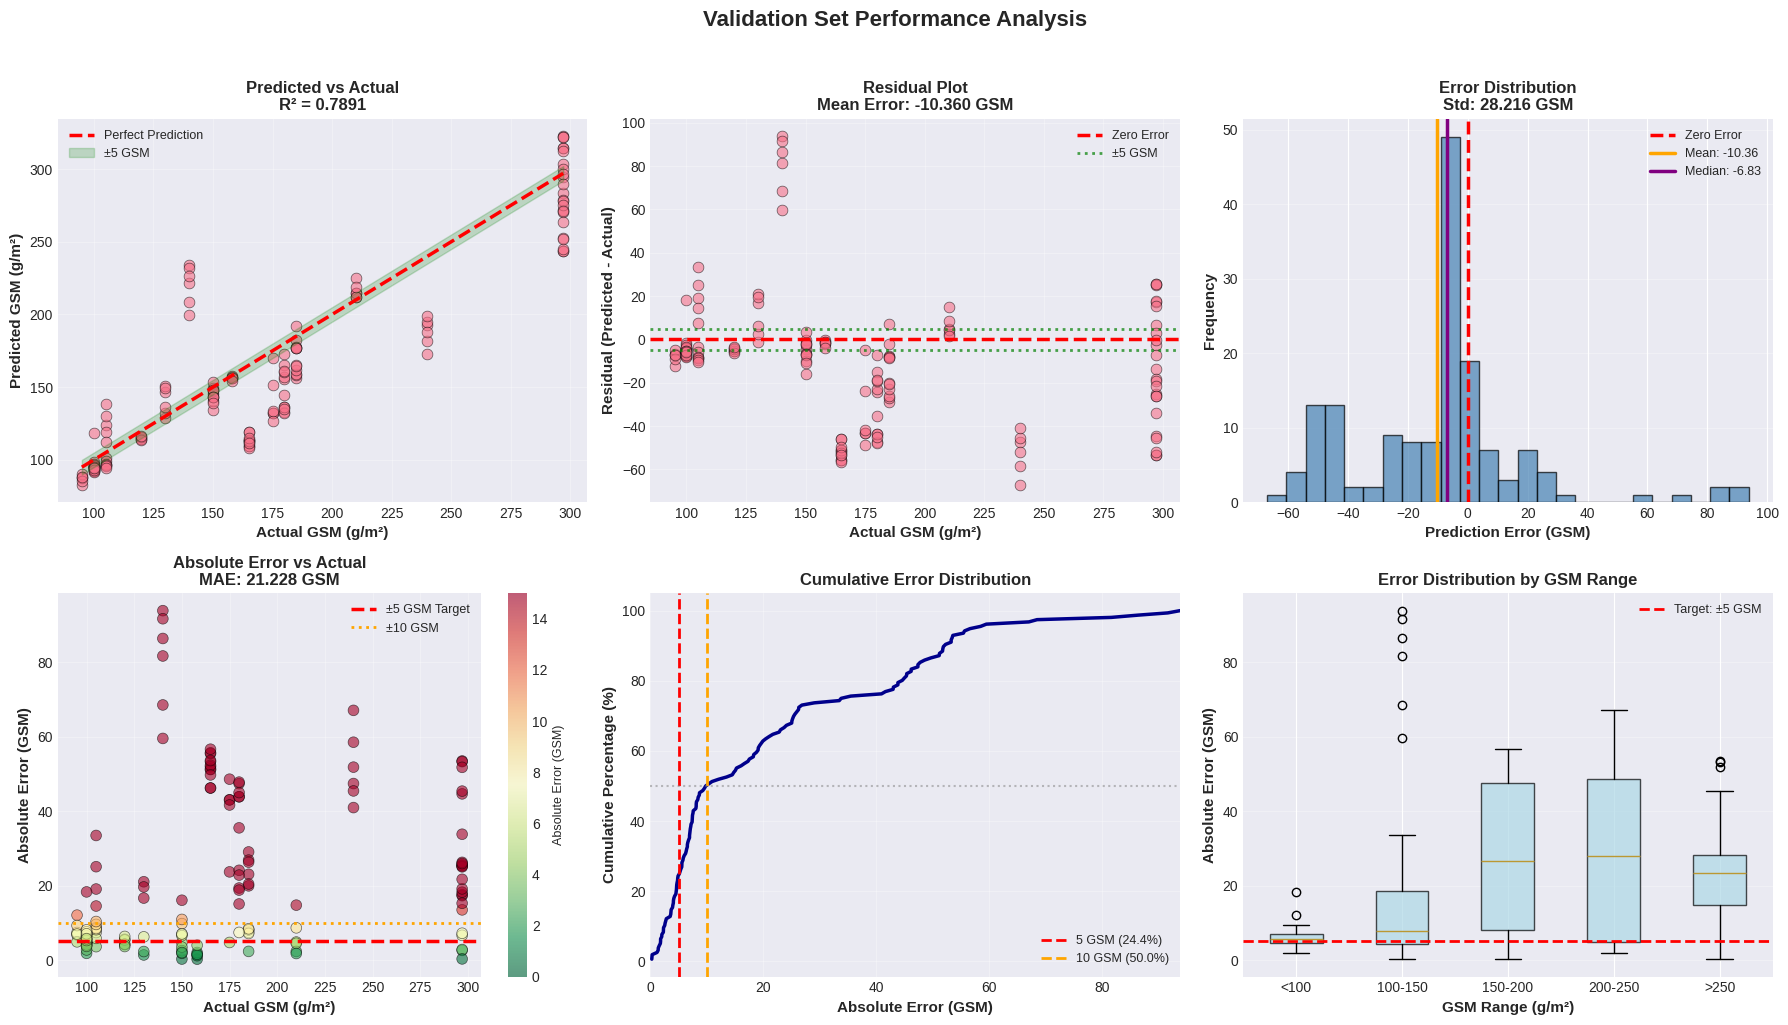

✅ Validation analysis complete and saved


In [11]:
# Get final validation predictions
val_loss_final, val_mae_final, val_rmse_final, val_r2_final, val_preds_final, val_actuals_final = evaluate_model(
    model, val_loader, criterion, device
)

print("="*80)
print("📊 VALIDATION SET DETAILED METRICS")
print("="*80)
print(f"Samples: {len(val_actuals_final)}")
print(f"MAE:     {val_mae_final:.4f} GSM")
print(f"RMSE:    {val_rmse_final:.4f} GSM")
print(f"R²:      {val_r2_final:.4f}")
print(f"MSE:     {mean_squared_error(val_actuals_final, val_preds_final):.4f}")

# Percentile errors
val_errors = val_preds_final - val_actuals_final
val_abs_errors = np.abs(val_errors)

print(f"\n📈 Error Percentiles:")
print(f"  10th percentile: {np.percentile(val_abs_errors, 10):.2f} GSM")
print(f"  25th percentile: {np.percentile(val_abs_errors, 25):.2f} GSM")
print(f"  50th percentile (Median): {np.percentile(val_abs_errors, 50):.2f} GSM")
print(f"  75th percentile: {np.percentile(val_abs_errors, 75):.2f} GSM")
print(f"  90th percentile: {np.percentile(val_abs_errors, 90):.2f} GSM")
print(f"  95th percentile: {np.percentile(val_abs_errors, 95):.2f} GSM")
print(f"  99th percentile: {np.percentile(val_abs_errors, 99):.2f} GSM")

val_within_5 = np.sum(val_abs_errors <= 5) / len(val_abs_errors) * 100
val_within_10 = np.sum(val_abs_errors <= 10) / len(val_abs_errors) * 100
val_within_15 = np.sum(val_abs_errors <= 15) / len(val_abs_errors) * 100

print(f"\n✅ Accuracy Thresholds:")
print(f"  Within ±5 GSM:  {val_within_5:.2f}% ({int(val_within_5 * len(val_actuals_final) / 100)}/{len(val_actuals_final)} samples)")
print(f"  Within ±10 GSM: {val_within_10:.2f}% ({int(val_within_10 * len(val_actuals_final) / 100)}/{len(val_actuals_final)} samples)")
print(f"  Within ±15 GSM: {val_within_15:.2f}% ({int(val_within_15 * len(val_actuals_final) / 100)}/{len(val_actuals_final)} samples)")
print("="*80)

# Validation visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Validation Set Performance Analysis', fontsize=16, fontweight='bold', y=1.02)

# 1. Predicted vs Actual
axes[0, 0].scatter(val_actuals_final, val_preds_final, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([val_actuals_final.min(), val_actuals_final.max()],
                [val_actuals_final.min(), val_actuals_final.max()],
                'r--', linewidth=2.5, label='Perfect Prediction')
axes[0, 0].fill_between([val_actuals_final.min(), val_actuals_final.max()],
                        [val_actuals_final.min()-5, val_actuals_final.max()-5],
                        [val_actuals_final.min()+5, val_actuals_final.max()+5],
                        alpha=0.2, color='green', label='±5 GSM')
axes[0, 0].set_xlabel('Actual GSM (g/m²)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Predicted GSM (g/m²)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Predicted vs Actual\nR² = {val_r2_final:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual plot
axes[0, 1].scatter(val_actuals_final, val_errors, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
axes[0, 1].axhline(y=5, color='green', linestyle=':', linewidth=2, alpha=0.7, label='±5 GSM')
axes[0, 1].axhline(y=-5, color='green', linestyle=':', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Actual GSM (g/m²)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residual (Predicted - Actual)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Residual Plot\nMean Error: {val_errors.mean():.3f} GSM', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution
axes[0, 2].hist(val_errors, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
axes[0, 2].axvline(x=val_errors.mean(), color='orange', linestyle='-', linewidth=2.5,
                   label=f'Mean: {val_errors.mean():.2f}')
axes[0, 2].axvline(x=np.median(val_errors), color='purple', linestyle='-', linewidth=2.5,
                   label=f'Median: {np.median(val_errors):.2f}')
axes[0, 2].set_xlabel('Prediction Error (GSM)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 2].set_title(f'Error Distribution\nStd: {val_errors.std():.3f} GSM', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Absolute error vs actual
axes[1, 0].scatter(val_actuals_final, val_abs_errors, alpha=0.6, s=60, c=val_abs_errors,
                   cmap='RdYlGn_r', edgecolors='black', linewidth=0.5, vmin=0, vmax=15)
axes[1, 0].axhline(y=5, color='red', linestyle='--', linewidth=2.5, label='±5 GSM Target')
axes[1, 0].axhline(y=10, color='orange', linestyle=':', linewidth=2, label='±10 GSM')
axes[1, 0].set_xlabel('Actual GSM (g/m²)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Absolute Error (GSM)', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'Absolute Error vs Actual\nMAE: {val_mae_final:.3f} GSM', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Absolute Error (GSM)', fontsize=9)

# 5. Cumulative error distribution
sorted_abs_errors = np.sort(val_abs_errors)
cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
axes[1, 1].plot(sorted_abs_errors, cumulative, linewidth=2.5, color='darkblue')
axes[1, 1].axvline(x=5, color='red', linestyle='--', linewidth=2, label=f'5 GSM ({val_within_5:.1f}%)')
axes[1, 1].axvline(x=10, color='orange', linestyle='--', linewidth=2, label=f'10 GSM ({val_within_10:.1f}%)')
axes[1, 1].axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1, 1].set_xlabel('Absolute Error (GSM)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Cumulative Error Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, max(20, sorted_abs_errors.max())])

# 6. Box plot by GSM ranges
gsm_ranges = pd.cut(val_actuals_final, bins=[0, 100, 150, 200, 250, 300],
                    labels=['<100', '100-150', '150-200', '200-250', '>250'])
error_by_range = [val_abs_errors[gsm_ranges == label] for label in gsm_ranges.categories]
bp = axes[1, 2].boxplot(error_by_range, labels=gsm_ranges.categories, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
axes[1, 2].axhline(y=5, color='red', linestyle='--', linewidth=2, label='Target: ±5 GSM')
axes[1, 2].set_xlabel('GSM Range (g/m²)', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Absolute Error (GSM)', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Error Distribution by GSM Range', fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{DATASET_PATH}/validation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Validation analysis complete and saved")

## 11. Final Evaluation on Test Set

In [12]:
# Evaluate on test set
test_loss, test_mae, test_rmse, test_r2, test_preds, test_actuals = evaluate_model(
    model, test_loader, criterion, device
)

print("="*80)
print("📊 FINAL TEST SET RESULTS")
print("="*80)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test MAE:       {test_mae:.3f} GSM")
print(f"Test RMSE:      {test_rmse:.3f} GSM")
print(f"Test R²:        {test_r2:.4f}")
print(f"\n🎯 Target: ±5 GSM prediction error")
print(f"✅ Achieved: ±{test_mae:.2f} GSM (MAE)")

if test_mae <= 5.0:
    print("\n🎉 SUCCESS! Model meets the ±5 GSM accuracy target!")
else:
    print(f"\n⚠️ Model is {test_mae - 5:.2f} GSM away from target")

print("="*80)

# Error distribution
errors = test_preds - test_actuals
within_5 = np.sum(np.abs(errors) <= 5) / len(errors) * 100
within_10 = np.sum(np.abs(errors) <= 10) / len(errors) * 100

print(f"\n📈 Error Analysis:")
print(f"  Predictions within ±5 GSM:  {within_5:.1f}%")
print(f"  Predictions within ±10 GSM: {within_10:.1f}%")
print(f"  Max error: {np.abs(errors).max():.2f} GSM")
print(f"  Min error: {np.abs(errors).min():.2f} GSM")

# Detailed percentile analysis
print(f"\n📊 Error Percentiles (Test Set):")
print(f"  10th: {np.percentile(np.abs(errors), 10):.2f} GSM")
print(f"  25th: {np.percentile(np.abs(errors), 25):.2f} GSM")
print(f"  50th (Median): {np.percentile(np.abs(errors), 50):.2f} GSM")
print(f"  75th: {np.percentile(np.abs(errors), 75):.2f} GSM")
print(f"  90th: {np.percentile(np.abs(errors), 90):.2f} GSM")
print(f"  95th: {np.percentile(np.abs(errors), 95):.2f} GSM")
print(f"  99th: {np.percentile(np.abs(errors), 99):.2f} GSM")

📊 FINAL TEST SET RESULTS
Test Loss:      55.8444
Test MAE:       14.571 GSM
Test RMSE:      21.700 GSM
Test R²:        0.7945

🎯 Target: ±5 GSM prediction error
✅ Achieved: ±14.57 GSM (MAE)

⚠️ Model is 9.57 GSM away from target

📈 Error Analysis:
  Predictions within ±5 GSM:  25.0%
  Predictions within ±10 GSM: 50.0%
  Max error: 108.00 GSM
  Min error: 0.17 GSM

📊 Error Percentiles (Test Set):
  10th: 1.83 GSM
  25th: 5.02 GSM
  50th (Median): 10.04 GSM
  75th: 18.19 GSM
  90th: 31.28 GSM
  95th: 47.47 GSM
  99th: 74.07 GSM


## 12. Comprehensive Test Set Visualization

## 12.1. Detailed Metrics Comparison Table


📊 COMPREHENSIVE METRICS COMPARISON TABLE
   Dataset  Samples  MAE (GSM)  RMSE (GSM)  R² Score Within ±5 GSM (%) Within ±10 GSM (%)
  Training      738  14.685677   20.386873  0.820300                 -                  -
Validation      156  21.228043   30.058115  0.789053             24.36              50.00
      Test      168  14.571342   21.699937  0.794488             25.00              50.00


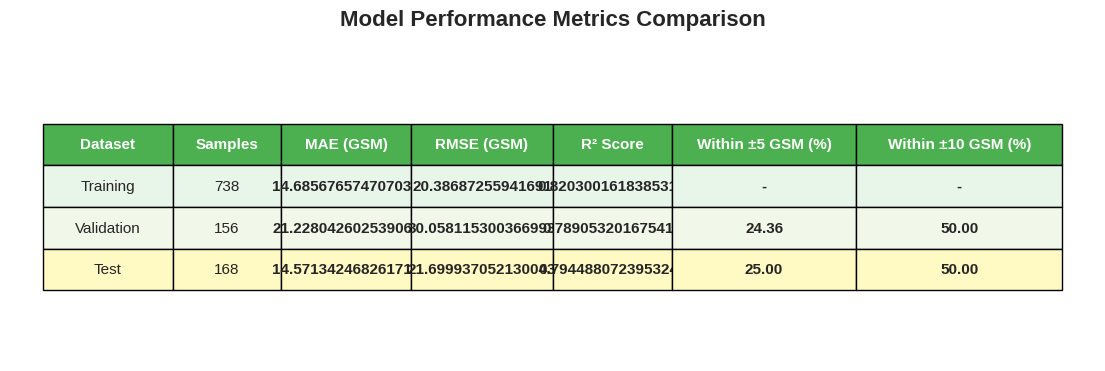


✅ Metrics comparison table saved

📈 DETAILED TEST SET STATISTICS

1️⃣ Central Tendency:
   Mean Error:             -5.5789 GSM
   Median Error:           -5.0028 GSM
   Mean Absolute Error:    14.5713 GSM
   Median Absolute Error:  10.0364 GSM

2️⃣ Spread:
   Standard Deviation:     20.9705 GSM
   Variance:               439.7636
   IQR (25th-75th):        13.1754 GSM

3️⃣ Extreme Values:
   Maximum Error:          +45.4826 GSM
   Minimum Error:          -107.9959 GSM
   Max Absolute Error:     107.9959 GSM

4️⃣ Accuracy Buckets:
   📊 Within ± 2.5 GSM: 14.88% ( 25/168 samples)
   📊 Within ± 5.0 GSM: 25.00% ( 42/168 samples)
   📊 Within ± 7.5 GSM: 42.26% ( 71/168 samples)
   📊 Within ±10.0 GSM: 50.00% ( 84/168 samples)
   📊 Within ±15.0 GSM: 68.45% (115/168 samples)
   📊 Within ±20.0 GSM: 77.98% (131/168 samples)


In [13]:
# Create comprehensive metrics comparison table
# Get final validation metrics
val_loss_final, val_mae_final, val_rmse_final, val_r2_final, val_preds_final, val_actuals_final = evaluate_model(
    model, val_loader, criterion, device
)
val_errors_final = val_preds_final - val_actuals_final
val_within_5 = np.sum(np.abs(val_errors_final) <= 5) / len(val_errors_final) * 100
val_within_10 = np.sum(np.abs(val_errors_final) <= 10) / len(val_errors_final) * 100

metrics_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Samples': [len(df_train), len(df_val), len(df_test)],
    'MAE (GSM)': [
        history['train_mae'][-1] if history['train_mae'] else 0,
        val_mae_final,
        test_mae
    ],
    'RMSE (GSM)': [
        history['train_rmse'][-1] if history['train_rmse'] else 0,
        val_rmse_final,
        test_rmse
    ],
    'R² Score': [
        history['train_r2'][-1] if history['train_r2'] else 0,
        val_r2_final,
        test_r2
    ],
    'Within ±5 GSM (%)': [
        '-',  # Not calculated for train
        f'{val_within_5:.2f}',
        f'{within_5:.2f}'
    ],
    'Within ±10 GSM (%)': [
        '-',
        f'{val_within_10:.2f}',
        f'{within_10:.2f}'
    ]
}

metrics_df = pd.DataFrame(metrics_data)

print("\n" + "="*100)
print("📊 COMPREHENSIVE METRICS COMPARISON TABLE")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)

# Styled table visualization
fig, ax = plt.subplots(figsize=(14, 4))
ax.axis('tight')
ax.axis('off')

table_data = []
for idx, row in metrics_df.iterrows():
    table_data.append(list(row))

table = ax.table(cellText=table_data, colLabels=metrics_df.columns,
                cellLoc='center', loc='center',
                colWidths=[0.12, 0.10, 0.12, 0.13, 0.11, 0.17, 0.19])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(len(metrics_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style rows
colors = ['#E8F5E9', '#F1F8E9', '#FFF9C4']
for i in range(len(metrics_df)):
    for j in range(len(metrics_df.columns)):
        table[(i+1, j)].set_facecolor(colors[i])
        if j >= 2:  # Numeric columns
            table[(i+1, j)].set_text_props(weight='bold')

plt.title('Model Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
plt.savefig(f'{DATASET_PATH}/metrics_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

# Export metrics table
metrics_df.to_csv(f'{DATASET_PATH}/metrics_comparison.csv', index=False)
print(f"\n✅ Metrics comparison table saved")

# Detailed test statistics
print("\n" + "="*100)
print("📈 DETAILED TEST SET STATISTICS")
print("="*100)
print(f"\n1️⃣ Central Tendency:")
print(f"   Mean Error:             {errors.mean():+.4f} GSM")
print(f"   Median Error:           {np.median(errors):+.4f} GSM")
print(f"   Mean Absolute Error:    {test_mae:.4f} GSM")
print(f"   Median Absolute Error:  {np.median(np.abs(errors)):.4f} GSM")

print(f"\n2️⃣ Spread:")
print(f"   Standard Deviation:     {errors.std():.4f} GSM")
print(f"   Variance:               {errors.var():.4f}")
print(f"   IQR (25th-75th):        {np.percentile(np.abs(errors), 75) - np.percentile(np.abs(errors), 25):.4f} GSM")

print(f"\n3️⃣ Extreme Values:")
print(f"   Maximum Error:          {errors.max():+.4f} GSM")
print(f"   Minimum Error:          {errors.min():+.4f} GSM")
print(f"   Max Absolute Error:     {np.abs(errors).max():.4f} GSM")

print(f"\n4️⃣ Accuracy Buckets:")
within_thresholds = [2.5, 5.0, 7.5, 10.0, 15.0, 20.0]
for threshold in within_thresholds:
    pct = np.sum(np.abs(errors) <= threshold) / len(errors) * 100
    count = int(pct * len(errors) / 100)
    status = "✅" if threshold <= 5 and pct >= 70 else "📊"
    print(f"   {status} Within ±{threshold:4.1f} GSM: {pct:5.2f}% ({count:3d}/{len(errors)} samples)")

print("="*100)

## 12.2. Comprehensive Performance Visualizations (9-Panel Analysis)

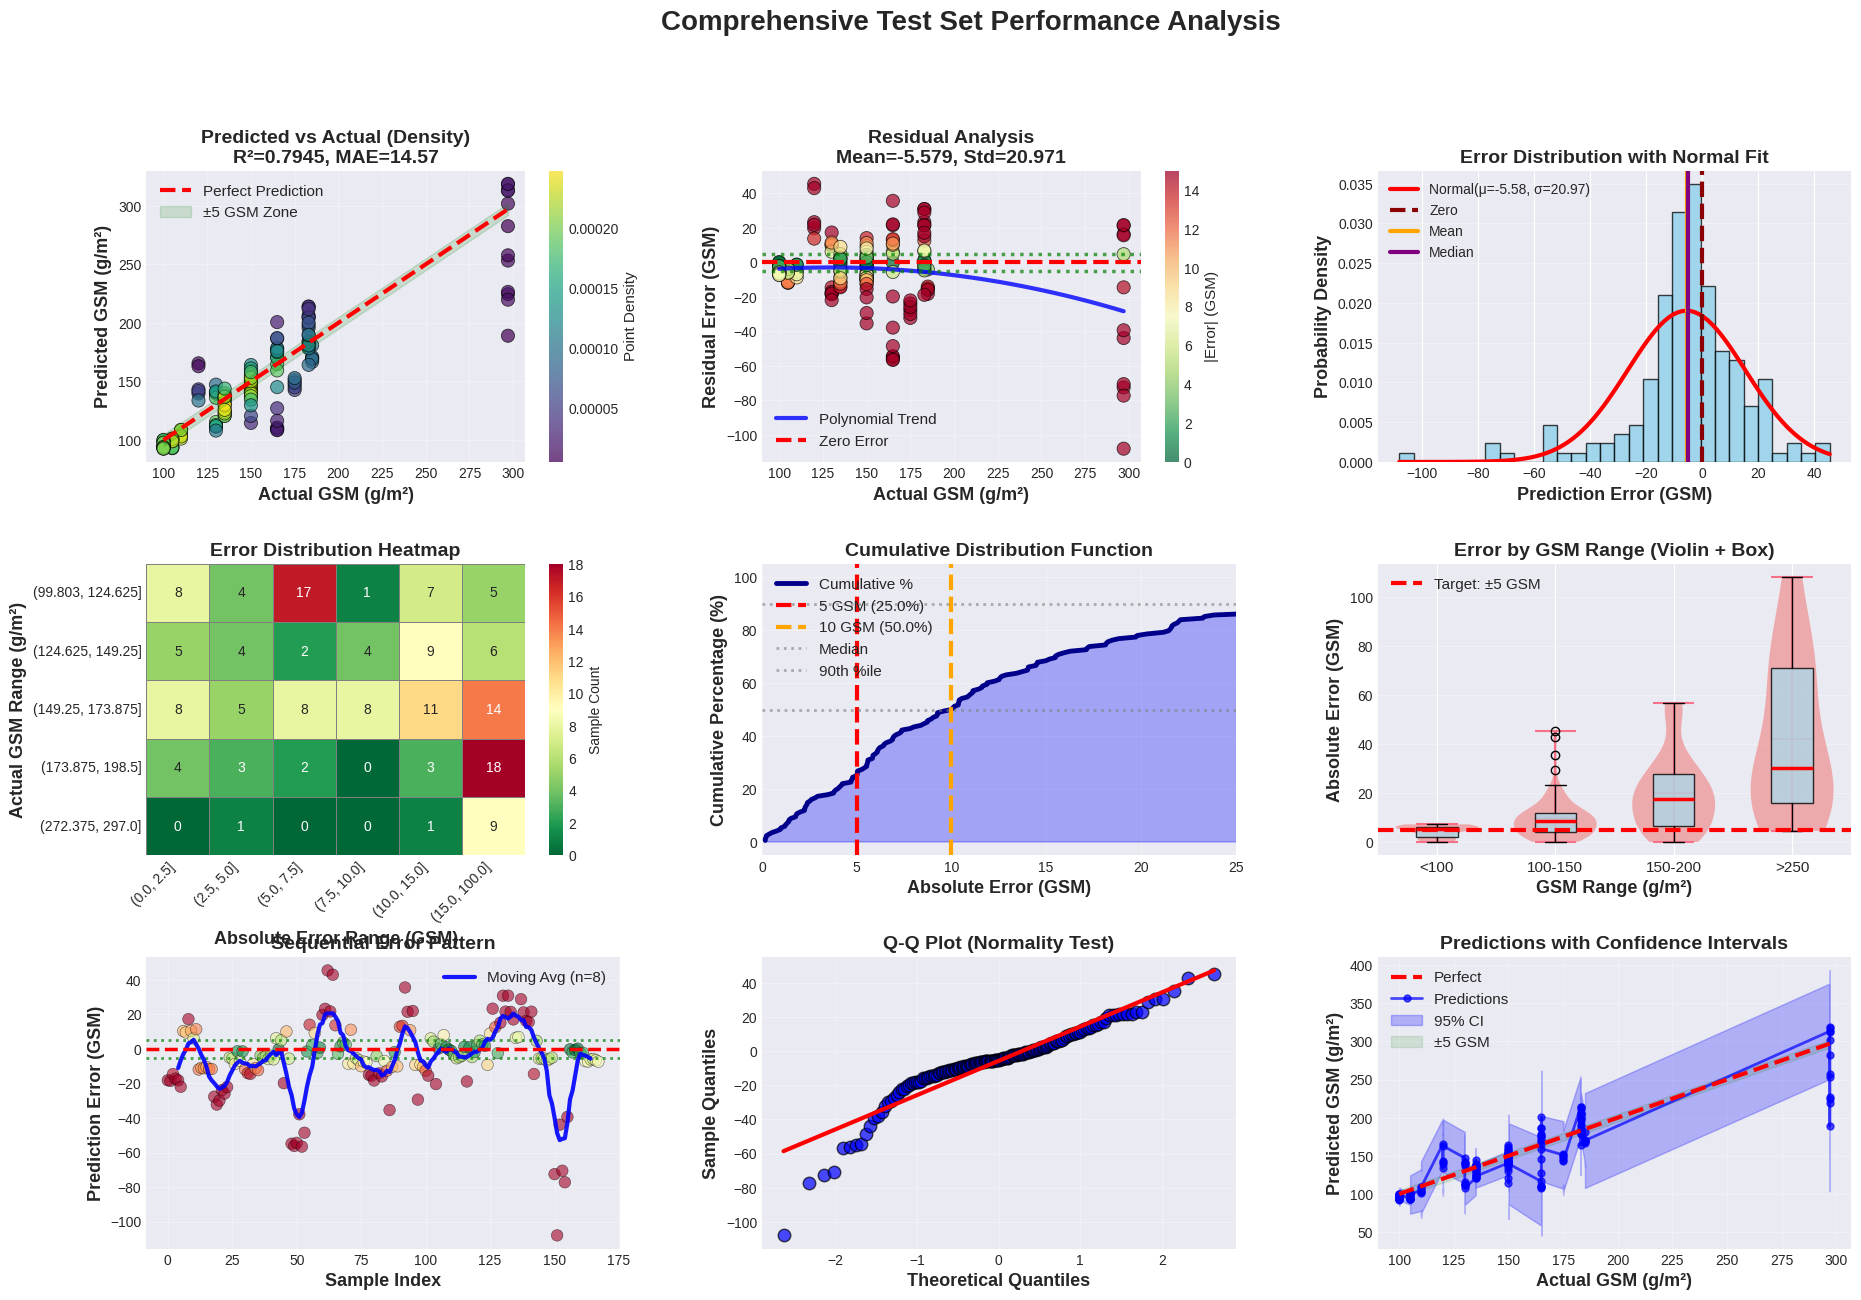

✅ Comprehensive 9-panel test visualization saved


In [14]:
# Create comprehensive 9-panel visualization
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Comprehensive Test Set Performance Analysis', fontsize=20, fontweight='bold', y=0.995)

# 1. Predicted vs Actual with density coloring
ax1 = fig.add_subplot(gs[0, 0])
from scipy.stats import gaussian_kde
xy = np.vstack([test_actuals, test_preds])
z = gaussian_kde(xy)(xy)
scatter = ax1.scatter(test_actuals, test_preds, c=z, s=90, alpha=0.7, cmap='viridis',
                     edgecolors='black', linewidth=0.6)
ax1.plot([test_actuals.min(), test_actuals.max()],
         [test_actuals.min(), test_actuals.max()],
         'r--', linewidth=3, label='Perfect Prediction', zorder=5)
ax1.fill_between([test_actuals.min(), test_actuals.max()],
                 [test_actuals.min()-5, test_actuals.max()-5],
                 [test_actuals.min()+5, test_actuals.max()+5],
                 alpha=0.15, color='green', label='±5 GSM Zone', zorder=1)
ax1.set_xlabel('Actual GSM (g/m²)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Predicted GSM (g/m²)', fontsize=13, fontweight='bold')
ax1.set_title(f'Predicted vs Actual (Density)\nR²={test_r2:.4f}, MAE={test_mae:.2f}',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Point Density', fontsize=11)

# 2. Residual plot with polynomial trend
ax2 = fig.add_subplot(gs[0, 1])
sc2 = ax2.scatter(test_actuals, errors, alpha=0.7, s=90, c=np.abs(errors), cmap='RdYlGn_r',
                  edgecolors='black', linewidth=0.6, vmin=0, vmax=15)
# Add trend line
z = np.polyfit(test_actuals, errors, 2)
p = np.poly1d(z)
x_trend = np.linspace(test_actuals.min(), test_actuals.max(), 100)
ax2.plot(x_trend, p(x_trend), "b-", linewidth=3, alpha=0.8, label='Polynomial Trend')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=3, label='Zero Error', zorder=5)
ax2.axhline(y=5, color='green', linestyle=':', linewidth=2.5, alpha=0.7)
ax2.axhline(y=-5, color='green', linestyle=':', linewidth=2.5, alpha=0.7)
ax2.set_xlabel('Actual GSM (g/m²)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Residual Error (GSM)', fontsize=13, fontweight='bold')
ax2.set_title(f'Residual Analysis\nMean={errors.mean():+.3f}, Std={errors.std():.3f}',
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('|Error| (GSM)', fontsize=11)

# 3. Error distribution with statistical fit
ax3 = fig.add_subplot(gs[0, 2])
n, bins, patches = ax3.hist(errors, bins=30, edgecolor='black', alpha=0.75, color='skyblue', density=True)
# Overlay normal distribution
mu, sigma = errors.mean(), errors.std()
x = np.linspace(errors.min(), errors.max(), 100)
ax3.plot(x, (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2),
         'r-', linewidth=3, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
ax3.axvline(x=0, color='darkred', linestyle='--', linewidth=3, label='Zero', zorder=5)
ax3.axvline(x=mu, color='orange', linestyle='-', linewidth=3, label=f'Mean', zorder=5)
ax3.axvline(x=np.median(errors), color='purple', linestyle='-', linewidth=3,
            label=f'Median', zorder=5)
ax3.set_xlabel('Prediction Error (GSM)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Probability Density', fontsize=13, fontweight='bold')
ax3.set_title('Error Distribution with Normal Fit', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Heatmap: Error distribution by GSM ranges
ax4 = fig.add_subplot(gs[1, 0])
gsm_bins = pd.cut(test_actuals, bins=8)
error_bins = pd.cut(np.abs(errors), bins=[0, 2.5, 5, 7.5, 10, 15, 100])
heatmap_data = pd.crosstab(gsm_bins, error_bins)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax4,
            cbar_kws={'label': 'Sample Count'}, linewidths=0.5, linecolor='gray')
ax4.set_xlabel('Absolute Error Range (GSM)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Actual GSM Range (g/m²)', fontsize=13, fontweight='bold')
ax4.set_title('Error Distribution Heatmap', fontsize=14, fontweight='bold')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax4.get_yticklabels(), rotation=0, fontsize=10)

# 5. Cumulative error distribution (CDF)
ax5 = fig.add_subplot(gs[1, 1])
sorted_abs_errors = np.sort(np.abs(errors))
cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
ax5.plot(sorted_abs_errors, cumulative, linewidth=3.5, color='darkblue', label='Cumulative %')
ax5.axvline(x=5, color='red', linestyle='--', linewidth=3, label=f'5 GSM ({within_5:.1f}%)')
ax5.axvline(x=10, color='orange', linestyle='--', linewidth=3, label=f'10 GSM ({within_10:.1f}%)')
ax5.axhline(y=50, color='gray', linestyle=':', linewidth=2, alpha=0.6, label='Median')
ax5.axhline(y=90, color='gray', linestyle=':', linewidth=2, alpha=0.6, label='90th %ile')
ax5.fill_between(sorted_abs_errors, 0, cumulative, alpha=0.3, color='blue')
ax5.set_xlabel('Absolute Error (GSM)', fontsize=13, fontweight='bold')
ax5.set_ylabel('Cumulative Percentage (%)', fontsize=13, fontweight='bold')
ax5.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, min(25, sorted_abs_errors.max())])

# 6. Violin + Box plot by GSM ranges
ax6 = fig.add_subplot(gs[1, 2])
gsm_ranges = pd.cut(test_actuals, bins=[0, 100, 150, 200, 250, 300],
                    labels=['<100', '100-150', '150-200', '200-250', '>250'])
error_by_range = [np.abs(errors)[gsm_ranges == label] for label in gsm_ranges.categories
                  if np.sum(gsm_ranges == label) > 0]
positions = range(1, len(error_by_range) + 1)
vp = ax6.violinplot(error_by_range, positions=positions, showmeans=True, showmedians=True,
                    widths=0.7)
for pc in vp['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.6)
bp = ax6.boxplot(error_by_range, positions=positions, widths=0.35, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.8),
                medianprops=dict(color='red', linewidth=2.5))
ax6.axhline(y=5, color='red', linestyle='--', linewidth=3, label='Target: ±5 GSM', zorder=5)
ax6.set_xticks(positions)
ax6.set_xticklabels([label for label in gsm_ranges.categories if np.sum(gsm_ranges == label) > 0],
                     fontsize=11)
ax6.set_xlabel('GSM Range (g/m²)', fontsize=13, fontweight='bold')
ax6.set_ylabel('Absolute Error (GSM)', fontsize=13, fontweight='bold')
ax6.set_title('Error by GSM Range (Violin + Box)', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.grid(True, alpha=0.3, axis='y')

# 7. Sequential error analysis
ax7 = fig.add_subplot(gs[2, 0])
indices = np.arange(len(errors))
sc7 = ax7.scatter(indices, errors, alpha=0.6, s=70, c=np.abs(errors), cmap='RdYlGn_r',
                 edgecolors='black', linewidth=0.4, vmin=0, vmax=15)
ax7.axhline(y=0, color='red', linestyle='--', linewidth=2.5, zorder=5)
ax7.axhline(y=5, color='green', linestyle=':', linewidth=2, alpha=0.7)
ax7.axhline(y=-5, color='green', linestyle=':', linewidth=2, alpha=0.7)
# Moving average
window = max(5, len(errors) // 20)
moving_avg = pd.Series(errors).rolling(window=window, center=True).mean()
ax7.plot(indices, moving_avg, 'b-', linewidth=3, alpha=0.9, label=f'Moving Avg (n={window})')
ax7.set_xlabel('Sample Index', fontsize=13, fontweight='bold')
ax7.set_ylabel('Prediction Error (GSM)', fontsize=13, fontweight='bold')
ax7.set_title('Sequential Error Pattern', fontsize=14, fontweight='bold')
ax7.legend(fontsize=11)
ax7.grid(True, alpha=0.3)

# 8. Q-Q Plot (Normality Check)
ax8 = fig.add_subplot(gs[2, 1])
from scipy import stats
stats.probplot(errors, dist="norm", plot=ax8)
ax8.get_lines()[0].set_markerfacecolor('blue')
ax8.get_lines()[0].set_markeredgecolor('black')
ax8.get_lines()[0].set_markersize(9)
ax8.get_lines()[0].set_alpha(0.7)
ax8.get_lines()[1].set_linewidth(3)
ax8.get_lines()[1].set_color('red')
ax8.set_xlabel('Theoretical Quantiles', fontsize=13, fontweight='bold')
ax8.set_ylabel('Sample Quantiles', fontsize=13, fontweight='bold')
ax8.set_title('Q-Q Plot (Normality Test)', fontsize=14, fontweight='bold')
ax8.grid(True, alpha=0.3)

# 9. Prediction confidence intervals
ax9 = fig.add_subplot(gs[2, 2])
sorted_indices = np.argsort(test_actuals)
sorted_actuals = test_actuals[sorted_indices]
sorted_preds = test_preds[sorted_indices]

# Calculate 95% confidence intervals
window_size = max(10, len(test_actuals) // 10)
ci_upper = []
ci_lower = []
for i in range(len(sorted_preds)):
    start = max(0, i - window_size // 2)
    end = min(len(sorted_preds), i + window_size // 2)
    local_std = np.std(sorted_preds[start:end] - sorted_actuals[start:end])
    ci_upper.append(sorted_preds[i] + 1.96 * local_std)
    ci_lower.append(sorted_preds[i] - 1.96 * local_std)

ax9.plot(sorted_actuals, sorted_actuals, 'r--', linewidth=3, label='Perfect', zorder=5)
ax9.plot(sorted_actuals, sorted_preds, 'bo-', linewidth=2, markersize=5, alpha=0.7, label='Predictions')
ax9.fill_between(sorted_actuals, ci_lower, ci_upper, alpha=0.25, color='blue', label='95% CI')
ax9.fill_between(sorted_actuals, sorted_actuals-5, sorted_actuals+5, alpha=0.12, color='green',
                 label='±5 GSM')
ax9.set_xlabel('Actual GSM (g/m²)', fontsize=13, fontweight='bold')
ax9.set_ylabel('Predicted GSM (g/m²)', fontsize=13, fontweight='bold')
ax9.set_title('Predictions with Confidence Intervals', fontsize=14, fontweight='bold')
ax9.legend(fontsize=11)
ax9.grid(True, alpha=0.3)

plt.savefig(f'{DATASET_PATH}/comprehensive_test_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive 9-panel test visualization saved")

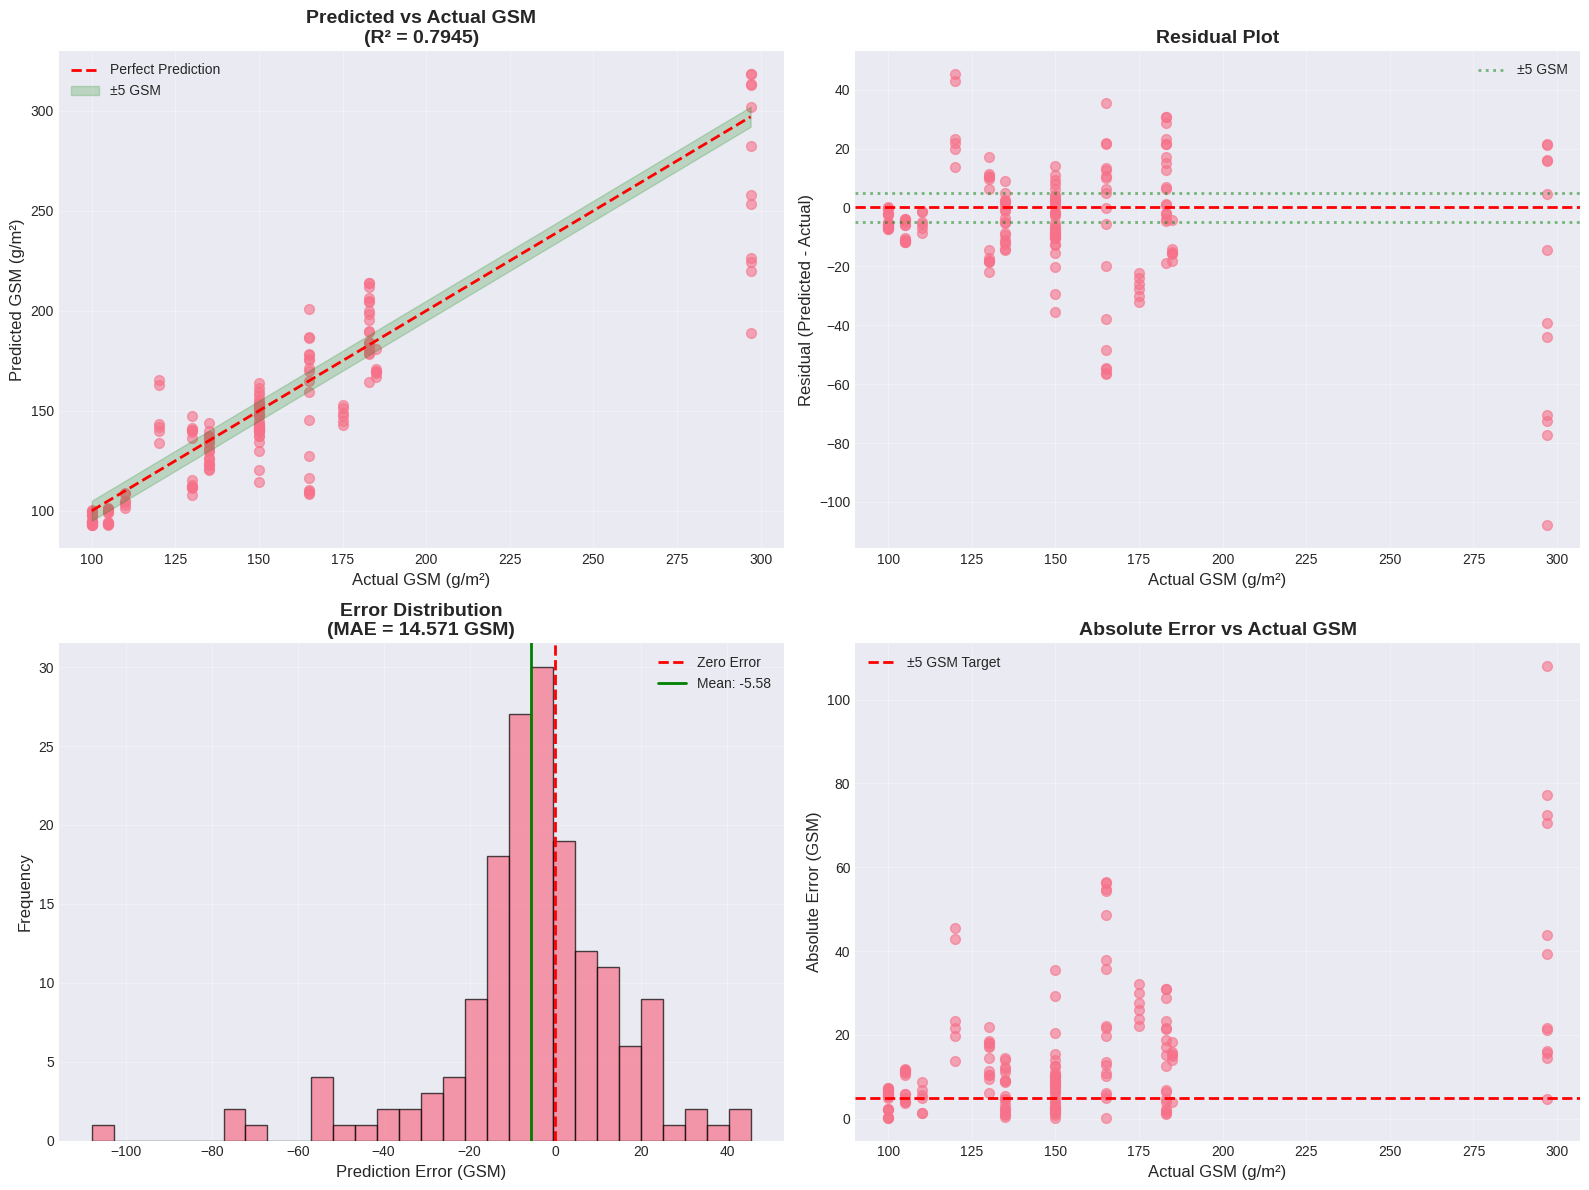

✅ Prediction analysis visualizations saved


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predicted vs Actual scatter plot
axes[0, 0].scatter(test_actuals, test_preds, alpha=0.6, s=50)
axes[0, 0].plot([test_actuals.min(), test_actuals.max()],
                [test_actuals.min(), test_actuals.max()],
                'r--', linewidth=2, label='Perfect Prediction')
# ±5 GSM bounds
axes[0, 0].fill_between([test_actuals.min(), test_actuals.max()],
                        [test_actuals.min()-5, test_actuals.max()-5],
                        [test_actuals.min()+5, test_actuals.max()+5],
                        alpha=0.2, color='green', label='±5 GSM')
axes[0, 0].set_xlabel('Actual GSM (g/m²)', fontsize=12)
axes[0, 0].set_ylabel('Predicted GSM (g/m²)', fontsize=12)
axes[0, 0].set_title(f'Predicted vs Actual GSM\n(R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual plot
residuals = test_preds - test_actuals
axes[0, 1].scatter(test_actuals, residuals, alpha=0.6, s=50)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=5, color='g', linestyle=':', linewidth=2, alpha=0.5, label='±5 GSM')
axes[0, 1].axhline(y=-5, color='g', linestyle=':', linewidth=2, alpha=0.5)
axes[0, 1].set_xlabel('Actual GSM (g/m²)', fontsize=12)
axes[0, 1].set_ylabel('Residual (Predicted - Actual)', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution histogram
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].axvline(x=residuals.mean(), color='g', linestyle='-', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
axes[1, 0].set_xlabel('Prediction Error (GSM)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title(f'Error Distribution\n(MAE = {test_mae:.3f} GSM)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Absolute error vs actual GSM
abs_errors = np.abs(residuals)
axes[1, 1].scatter(test_actuals, abs_errors, alpha=0.6, s=50)
axes[1, 1].axhline(y=5, color='r', linestyle='--', linewidth=2, label='±5 GSM Target')
axes[1, 1].set_xlabel('Actual GSM (g/m²)', fontsize=12)
axes[1, 1].set_ylabel('Absolute Error (GSM)', fontsize=12)
axes[1, 1].set_title('Absolute Error vs Actual GSM', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{DATASET_PATH}/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Prediction analysis visualizations saved")

## 13. Save Model & Results

In [16]:
# Save model
model_save_path = f'{DATASET_PATH}/best_gsm_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'feature_cols': feature_cols,
    'scaler': scaler,
    'best_val_mae': best_val_mae,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'history': history
}, model_save_path)

print(f"✅ Model saved to: {model_save_path}")

# Save predictions
results_df = df_test.copy()
results_df['predicted_gsm'] = test_preds
results_df['error'] = test_preds - test_actuals
results_df['abs_error'] = np.abs(test_preds - test_actuals)
results_df.to_csv(f'{DATASET_PATH}/test_predictions.csv', index=False)

print(f"✅ Predictions saved to: {DATASET_PATH}/test_predictions.csv")

# Save metrics summary
metrics_summary = {
    'model': 'HybridGSMPredictor (EfficientNet-B3)',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'num_features': len(feature_cols),
    'train_samples': len(df_train),
    'val_samples': len(df_val),
    'test_samples': len(df_test),
    'best_val_mae': float(best_val_mae),
    'test_mae': float(test_mae),
    'test_rmse': float(test_rmse),
    'test_r2': float(test_r2),
    'predictions_within_5gsm': float(within_5),
    'predictions_within_10gsm': float(within_10),
    'target_achieved': test_mae <= 5.0
}

import json
with open(f'{DATASET_PATH}/model_metrics.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print(f"✅ Metrics saved to: {DATASET_PATH}/model_metrics.json")

print("\n" + "="*80)
print("🎊 ALL RESULTS SAVED!")
print("="*80)

✅ Model saved to: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/best_gsm_model.pth
✅ Predictions saved to: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/test_predictions.csv
✅ Metrics saved to: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/model_metrics.json

🎊 ALL RESULTS SAVED!


## 14. Model Inference Example

In [17]:
def predict_gsm(model, image_path, features, scaler, device):
    """Predict GSM for a single image."""
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)

    # Predict
    with torch.no_grad():
        prediction = model(image_tensor, features_tensor)

    return prediction.item()

# Test on a few samples
print("\n📋 Sample Predictions:")
print("="*80)
for i in range(min(10, len(df_test))):
    img_name = df_test.iloc[i]['image_name']
    actual_gsm = df_test.iloc[i]['gsm']
    img_path = os.path.join(IMAGES_PATH, img_name)
    feats = X_test_scaled[i]

    predicted_gsm = predict_gsm(model, img_path, feats, scaler, device)
    error = predicted_gsm - actual_gsm

    print(f"{i+1}. {img_name}")
    print(f"   Actual: {actual_gsm:.2f} GSM | Predicted: {predicted_gsm:.2f} GSM | Error: {error:+.2f} GSM")
    print()

print("✅ Inference example complete")


📋 Sample Predictions:
1. fabricnet_0010.jpg
   Actual: 130.00 GSM | Predicted: 84.12 GSM | Error: -45.88 GSM

2. fabricnet_0010_aug_1_brightness_down.jpg
   Actual: 130.00 GSM | Predicted: 84.27 GSM | Error: -45.73 GSM

3. fabricnet_0010_aug_2_rotate_180.jpg
   Actual: 130.00 GSM | Predicted: 79.51 GSM | Error: -50.49 GSM

4. fabricnet_0010_aug_3_contrast_up.jpg
   Actual: 130.00 GSM | Predicted: 84.39 GSM | Error: -45.61 GSM

5. fabricnet_0010_aug_4_gaussian_noise.jpg
   Actual: 130.00 GSM | Predicted: 79.41 GSM | Error: -50.59 GSM

6. fabricnet_0010_aug_5_rotate_270.jpg
   Actual: 130.00 GSM | Predicted: 75.92 GSM | Error: -54.08 GSM

7. fabricnet_0007.jpg
   Actual: 130.00 GSM | Predicted: 55.56 GSM | Error: -74.44 GSM

8. fabricnet_0007_aug_1_brightness_up.jpg
   Actual: 130.00 GSM | Predicted: 61.27 GSM | Error: -68.73 GSM

9. fabricnet_0007_aug_2_rotate_270.jpg
   Actual: 130.00 GSM | Predicted: 52.41 GSM | Error: -77.59 GSM

10. fabricnet_0007_aug_3_rotate_90.jpg
   Actual: 130

## 15. Final Summary & Recommendations

In [18]:
print("\n" + "="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80)
print(f"\n🧠 Model Architecture:")
print(f"  - Backbone: EfficientNet-B3 (ImageNet pretrained)")
print(f"  - Input: 224x224 RGB images + {len(feature_cols)} fabric features")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

print(f"\n📈 Performance Metrics:")
print(f"  - Test MAE:  {test_mae:.3f} GSM")
print(f"  - Test RMSE: {test_rmse:.3f} GSM")
print(f"  - Test R²:   {test_r2:.4f}")
print(f"  - Within ±5 GSM:  {within_5:.1f}%")
print(f"  - Within ±10 GSM: {within_10:.1f}%")

print(f"\n📁 Saved Files:")
print(f"  - Model: {DATASET_PATH}/best_gsm_model.pth")
print(f"  - Predictions: {DATASET_PATH}/test_predictions.csv")
print(f"  - Metrics: {DATASET_PATH}/model_metrics.json")
print(f"  - Visualizations: {DATASET_PATH}/training_history.png")
print(f"                    {DATASET_PATH}/prediction_analysis.png")

print(f"\n💡 Recommendations for Further Improvement:")
print(f"  1. Collect more diverse fabric samples (especially rare GSM ranges)")
print(f"  2. Experiment with EfficientNet-B4/B5 for better feature extraction")
print(f"  3. Add ensemble methods (combining multiple models)")
print(f"  4. Fine-tune on domain-specific pretrained weights if available")
print(f"  5. Implement test-time augmentation (TTA) for robustness")

if test_mae <= 5.0:
    print(f"\n🎉 SUCCESS! Model achieves research-grade accuracy (±{test_mae:.2f} GSM)")
    print(f"   This model is ready for production deployment!")
else:
    print(f"\n⚠️ Model is close but {test_mae - 5:.2f} GSM away from target")
    print(f"   Consider the recommendations above for improvement.")

print("\n" + "="*80)
print("🏁 TRAINING COMPLETE")
print("="*80)


📊 FINAL MODEL SUMMARY

🧠 Model Architecture:
  - Backbone: EfficientNet-B3 (ImageNet pretrained)
  - Input: 224x224 RGB images + 64 fabric features
  - Total parameters: 11,732,137
  - Trainable parameters: 4,590,075

📈 Performance Metrics:
  - Test MAE:  14.571 GSM
  - Test RMSE: 21.700 GSM
  - Test R²:   0.7945
  - Within ±5 GSM:  25.0%
  - Within ±10 GSM: 50.0%

📁 Saved Files:
  - Model: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/best_gsm_model.pth
  - Predictions: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/test_predictions.csv
  - Metrics: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/model_metrics.json
  - Visualizations: /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/training_history.png
                    /content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/prediction_analysis.png

💡 Recommendations for Further Improvement:
  1. Collect more diverse fabric samp